# Fertilizer effect on crop yield

We'll explore how not controlling for confounders affects our estimates in a Bayesian regression scenario. More specifically, the posterior distribution of the parameters is shown to be biased.

Causal Model:
- Treatment (F): Fertilizer use (binary: 0 or 1)
- Outcome (C): Crop yield (continuous)
- Confounder (pH): Soil pH level (continuous)

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

**Define the true relationships**

We'll define a data-generating process where:
1. pH affects both fertilizer use and crop yield
2. Fertilizer affects crop yield
   
This creates a classic confounding scenario where pH is a common cause of both treatment and outcome.

In [2]:
n_samples = 1000
true_effect_fertilizer = 5

# Generate soil pH levels (the confounder)
pH = np.random.normal(loc=7, scale=1, size=n_samples)

# Generate fertilizer use (treatment) influenced by pH
# Higher pH makes fertilizer use more likely
prob_fertilizer = 1 / (1 + np.exp(-(pH - 7)))
fertilizer = np.random.binomial(n=1, p=prob_fertilizer, size=n_samples)

# Generate crop yield (outcome) influenced by both pH and fertilizer
# pH has a nonlinear effect on yield, with optimal growth around pH 6.5
pH_effect = -2 * (pH - 6.5) ** 2 + 5
crop_yield = (
    10 + pH_effect + true_effect_fertilizer * fertilizer + np.random.normal(0, 2, n_samples)
)

# Create a DataFrame with all variables
data = pd.DataFrame({"pH": pH, "fertilizer": fertilizer, "crop_yield": crop_yield})
data.head()

,pH,fertilizer,crop_yield
0,7.496714,1,17.394704
1,6.861736,0,13.233982
2,7.647689,1,18.003971
3,8.523030,1,14.495601
4,6.765847,0,11.108306


**Explore the Data**

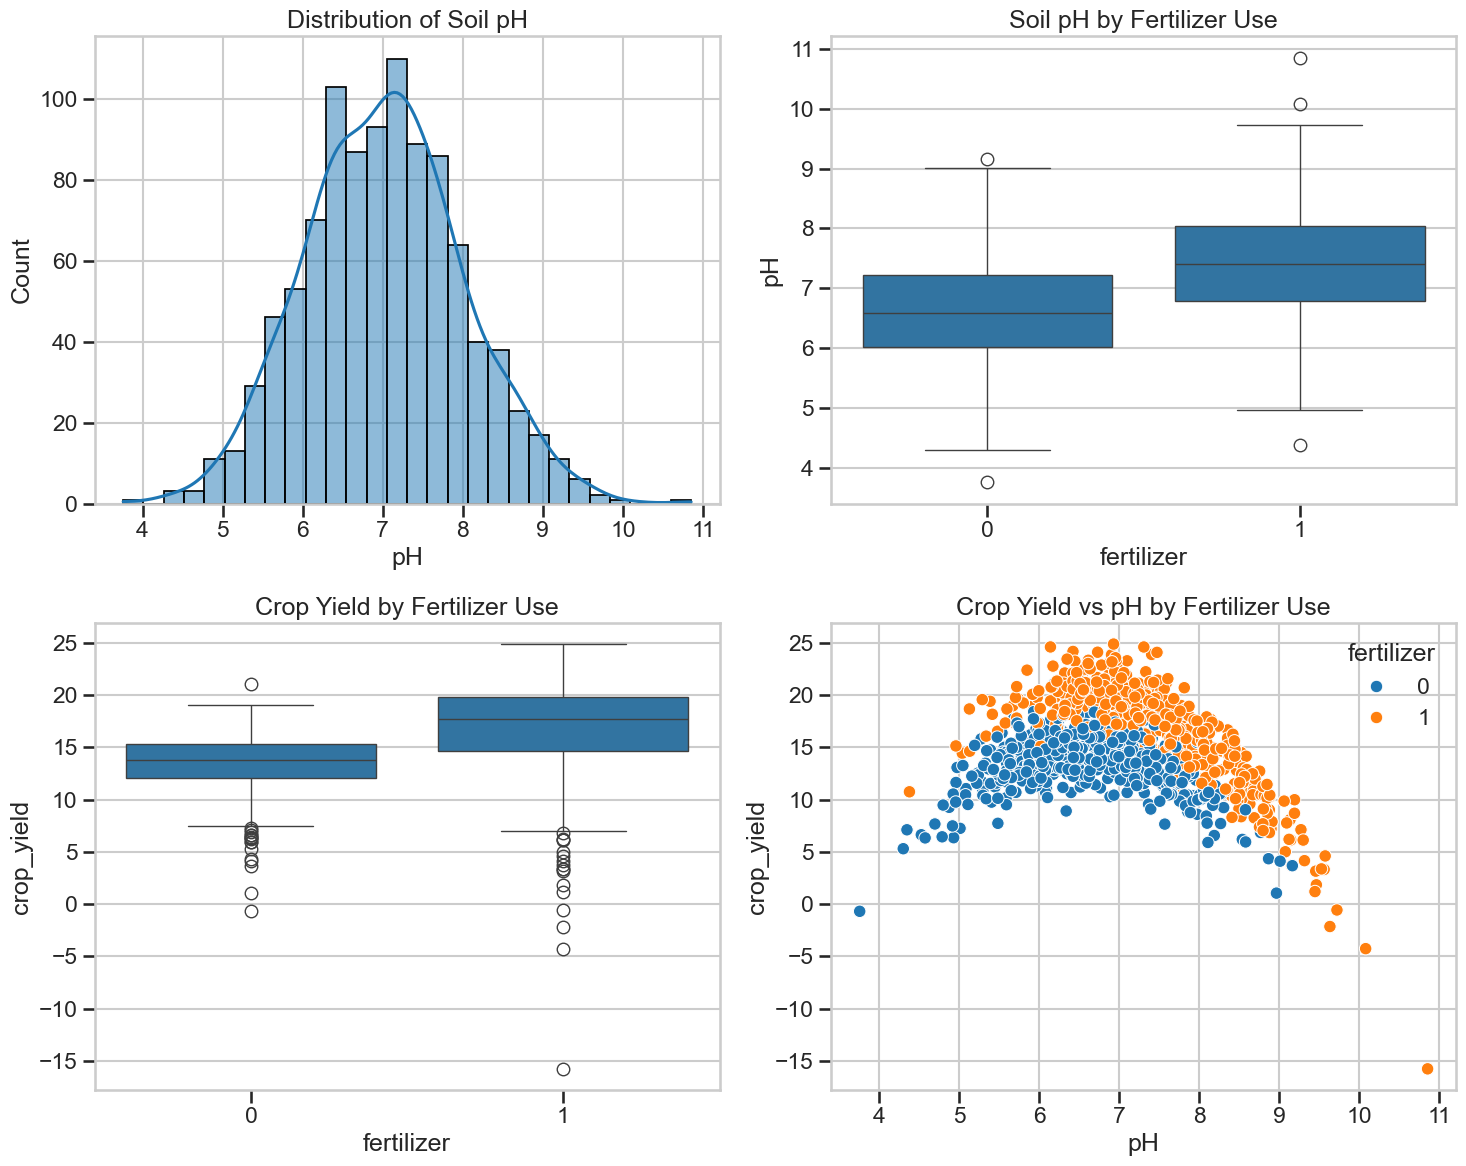

Average crop yield without fertilizer: 13.45
Average crop yield with fertilizer: 16.64

Naive difference in means, which is biased: 3.18
True causal effect: 5


In [10]:
# Plot distributions and relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot pH distribution
sns.histplot(data=data, x='pH', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Soil pH')

# Plot relationship between pH and fertilizer
sns.boxplot(data=data, x='fertilizer', y='pH', ax=axes[0, 1])
axes[0, 1].set_title('Soil pH by Fertilizer Use')

# Plot relationship between fertilizer and crop yield
sns.boxplot(data=data, x='fertilizer', y='crop_yield', ax=axes[1, 0])
axes[1, 0].set_title('Crop Yield by Fertilizer Use')

# Plot relationship between pH and crop yield, colored by fertilizer
sns.scatterplot(data=data, x='pH', y='crop_yield', hue='fertilizer', ax=axes[1, 1])
axes[1, 1].set_title('Crop Yield vs pH by Fertilizer Use')

plt.tight_layout()
plt.show()

# Calculate some summary statistics to see the confounding effect
no_fertilizer_mean = data[data.fertilizer == 0].crop_yield.mean()
fertilizer_mean = data[data.fertilizer == 1].crop_yield.mean()
print(f"Average crop yield without fertilizer: {no_fertilizer_mean:.2f}")
print(f"Average crop yield with fertilizer: {fertilizer_mean:.2f}\n")
print(f"Naive difference in means, which is biased: {fertilizer_mean - no_fertilizer_mean:.2f}")
print(f"True causal effect: {true_effect_fertilizer}") 

**Bayesian Linear Regression**

Now we'll implement two Bayesian linear regression models:

1. **Naive model**: Ignores the confounder (pH)
2. **Adjusted model**: Controls for the confounder (pH)

We'll compare how well each model recovers the true causal effect of fertilizer on crop yield.

In [ ]:
# Standardize variables for better MCMC convergence
data_std = data.copy()
data_std["pH_std"] = (data["pH"] - data["pH"].mean()) / data["pH"].std()
data_std["crop_yield_std"] = (data["crop_yield"] - data["crop_yield"].mean()) / data[
    "crop_yield"
].std()

# 1. Naive model (ignoring the confounder)
with pm.Model() as naive_model:
    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_fertilizer = pm.Normal("beta_fertilizer", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)
    # Linear model
    mu = alpha + beta_fertilizer * data_std["fertilizer"]
    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data_std["crop_yield_std"])
    # Inference
    naive_trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# 2. Adjusted model (controlling for the confounder)
with pm.Model() as adjusted_model:
    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_fertilizer = pm.Normal("beta_fertilizer", mu=0, sigma=10)
    beta_pH = pm.Normal("beta_pH", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)
    # Linear model with pH and pH squared to capture nonlinear effects
    mu = (
        alpha
        + beta_fertilizer * data_std["fertilizer"]
        + beta_pH * data_std["pH_std"]
    )
    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data_std["crop_yield_std"])
    # Inference
    adjusted_trace = pm.sample(5000, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_fertilizer, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_fertilizer, beta_pH, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


## 4. Compare Model Results

Now we'll examine the posterior distributions of the fertilizer effect from both models and compare them to the true causal effect.

Naive model effect estimate: 3.18 (95% CI: [2.72, 3.65])
Adjusted model effect estimate: 4.94 (95% CI: [4.49, 5.39])
True causal effect: 5.00


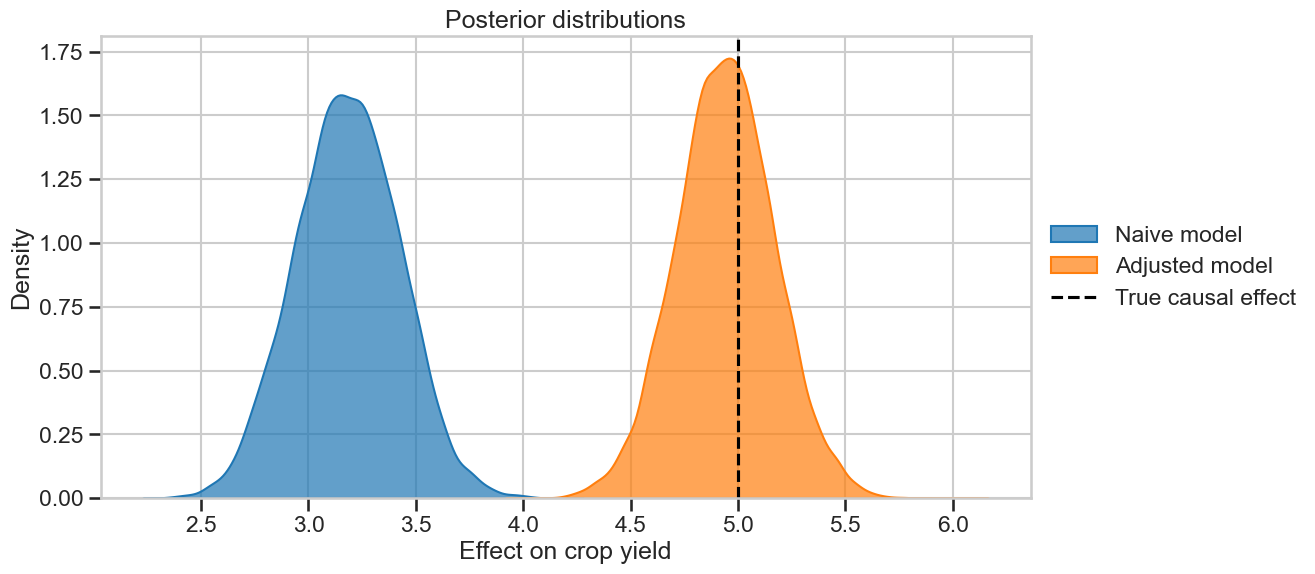

In [27]:
# Extract the posterior samples for the fertilizer effect
naive_effect = naive_trace.posterior["beta_fertilizer"].values.flatten()
adjusted_effect = adjusted_trace.posterior["beta_fertilizer"].values.flatten()

# Rescale effects to original units (undo standardization)
std_y = data["crop_yield"].std()
naive_effect_rescaled = naive_effect * std_y
adjusted_effect_rescaled = adjusted_effect * std_y

# Plot the posterior distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(naive_effect_rescaled, fill=True, label="Naive model", alpha=0.7)
sns.kdeplot(
    adjusted_effect_rescaled, fill=True, label="Adjusted model", alpha=0.7
)
plt.axvline(x=true_effect_fertilizer, color="k", linestyle="--", label="True causal effect")
plt.title("Posterior distributions")
plt.xlabel("Effect on crop yield")
plt.ylabel("Density")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Calculate summary statistics
print(
    "Naive model effect estimate: {:.2f} (95% CI: [{:.2f}, {:.2f}])".format(
        naive_effect_rescaled.mean(),
        np.percentile(naive_effect_rescaled, 2.5),
        np.percentile(naive_effect_rescaled, 97.5),
    )
)
print(
    "Adjusted model effect estimate: {:.2f} (95% CI: [{:.2f}, {:.2f}])".format(
        adjusted_effect_rescaled.mean(),
        np.percentile(adjusted_effect_rescaled, 2.5),
        np.percentile(adjusted_effect_rescaled, 97.5),
    )
)
print("True causal effect: {:.2f}".format(true_effect_fertilizer))

**Explore the Full Posterior Results**

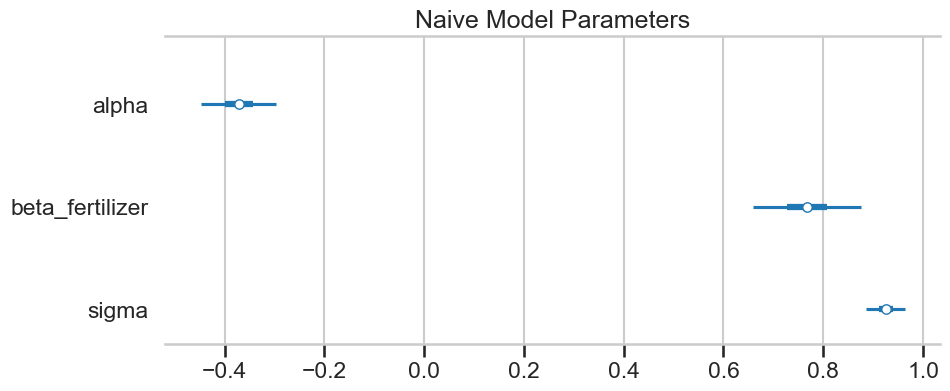

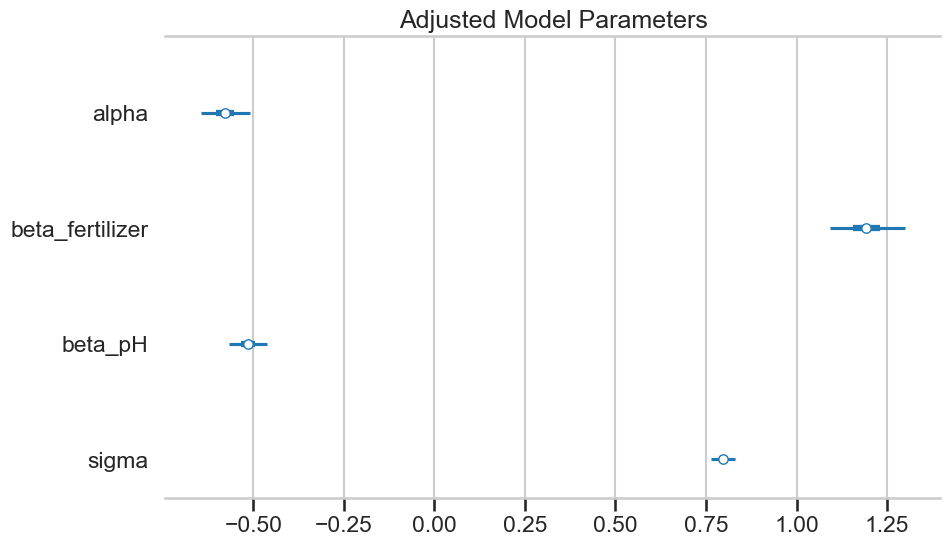

Naive Model Summary:
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha           -0.372  0.041  -0.448   -0.296      0.001    0.000    4207.0   
beta_fertilizer  0.768  0.058   0.659    0.875      0.001    0.001    4012.0   
sigma            0.925  0.021   0.887    0.964      0.000    0.000    6365.0   

                 ess_tail  r_hat  
alpha              4981.0    1.0  
beta_fertilizer    5245.0    1.0  
sigma              5527.0    1.0  

Adjusted Model Summary:
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha           -0.577  0.037  -0.645   -0.508        0.0      0.0   13007.0   
beta_fertilizer  1.192  0.055   1.092    1.300        0.0      0.0   12421.0   
beta_pH         -0.515  0.028  -0.566   -0.463        0.0      0.0   15403.0   
sigma            0.797  0.018   0.764    0.830        0.0      0.0   16281.0   

                 ess_tail  r_hat  
alpha             14019.0    1.0  
beta_fertilizer   1348

In [19]:
# Forest plot for naive model
az.plot_forest(naive_trace, var_names=['alpha', 'beta_fertilizer', 'sigma'], 
               figsize=(10, 4), combined=True)
plt.title('Naive Model Parameters')
plt.show()

# Forest plot for adjusted model
az.plot_forest(adjusted_trace, var_names=['alpha', 'beta_fertilizer', 'beta_pH', 'sigma'], 
               figsize=(10, 6), combined=True)
plt.title('Adjusted Model Parameters')
plt.show()

# Summary statistics
naive_summary = az.summary(naive_trace, var_names=['alpha', 'beta_fertilizer', 'sigma'])
adjusted_summary = az.summary(adjusted_trace, var_names=['alpha', 'beta_fertilizer', 'beta_pH', 'sigma'])

print("Naive Model Summary:")
print(naive_summary)
print("\nAdjusted Model Summary:")
print(adjusted_summary)

**Conclusions**

From our analysis, we can draw the following conclusions:

1. **Naive model (ignoring pH)**: When we ignore the confounder (soil pH), our estimate of the fertilizer effect is biased. The posterior distribution of the effect does not correctly center on the true causal effect.

2. **Adjusted model (controlling for pH)**: When we control for the confounder, our estimate is much closer to the true causal effect, and the true value falls within our credible interval.

So... **controlling for confounders is essential for obtaining unbiased estimates of causal effects**. When we ignore confounders, we get a misleading picture of the relationship between treatment and outcome.